In [1]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import os
import sys
import csv
import talib
from   scipy.stats       import norm
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import mplfinance        as mpf

In [2]:
timeframe = '1H'

df_ = pd.read_csv("./data/USDJPY.csv", parse_dates=True, index_col="datetime")

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
datetime,,,,,
2000-01-02 23:00:00+00:00,102.140,102.260,102.120,102.200,104
2000-01-03 00:00:00+00:00,102.200,102.220,102.030,102.050,80
2000-01-03 01:00:00+00:00,102.070,102.070,101.900,101.990,90
2000-01-03 02:00:00+00:00,102.000,102.030,101.840,101.920,138
2000-01-03 03:00:00+00:00,101.920,102.000,101.880,101.930,85
...,...,...,...,...,...
2023-08-09 23:00:00+00:00,143.664,143.756,143.631,143.716,980
2023-08-10 00:00:00+00:00,143.716,143.885,143.683,143.805,2879
2023-08-10 01:00:00+00:00,143.806,143.841,143.731,143.772,2416


mean    : 50.59424251169083
std.dev : 12.37742846819686
sigma lower : 25.8
sigma upper : 75.3


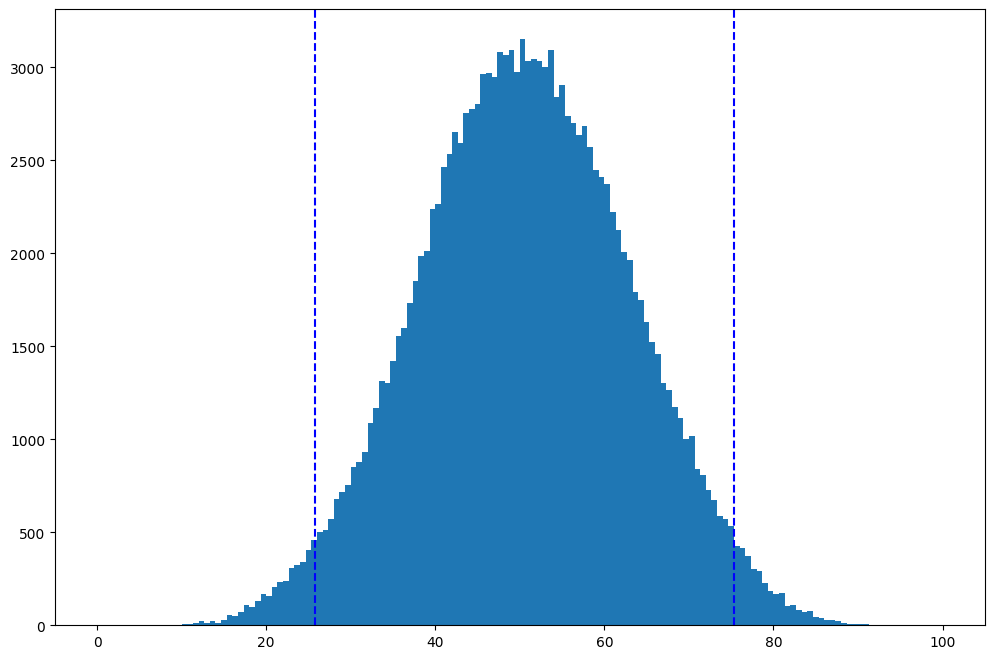

In [3]:
rsi_period = 14
sigma      = 2.0

df[f"rsi_{rsi_period}"] = talib.RSI(df['Close'], timeperiod=rsi_period)

rsi_values = df[f"rsi_{rsi_period}"].values
rsi_values = rsi_values[~np.isnan(rsi_values)]

rsi_mean, rsi_stdev = norm.fit(rsi_values)
print(f"mean    : {rsi_mean}")
print(f"std.dev : {rsi_stdev}")

sigma_lower = round(rsi_mean - sigma*rsi_stdev, 1)
sigma_upper = round(rsi_mean + sigma*rsi_stdev, 1)

print(f"sigma lower : {sigma_lower}")
print(f"sigma upper : {sigma_upper}")

_, axs = plt.subplots(1, figsize=(12, 8))
axs.hist(df[f"rsi_{rsi_period}"].values, bins=150, range=(0.0, 100.0));
plt.axvline(x=sigma_lower, color='b', label = 'sigma lower', linestyle='--')
plt.axvline(x=sigma_upper, color='b', label = 'sigma upper', linestyle='--')

In [4]:
# RSI signals extraction 

rsi_upper  = sigma_upper
rsi_lower  = sigma_lower


df['position'] = np.nan
# Long positions, if RSI cross up rsi_lower level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)<rsi_lower) & (df[f"rsi_{rsi_period}"]>=rsi_lower),
    'position'] = 1
# Short position, if RSI cross down rsi_upper level
df.loc[
    (df[f"rsi_{rsi_period}"].shift(1)>rsi_upper) & (df[f"rsi_{rsi_period}"]<=rsi_upper),
    'position'] = -1

df['position'].value_counts()

position
 1.0    1161
-1.0    1043
Name: count, dtype: int64

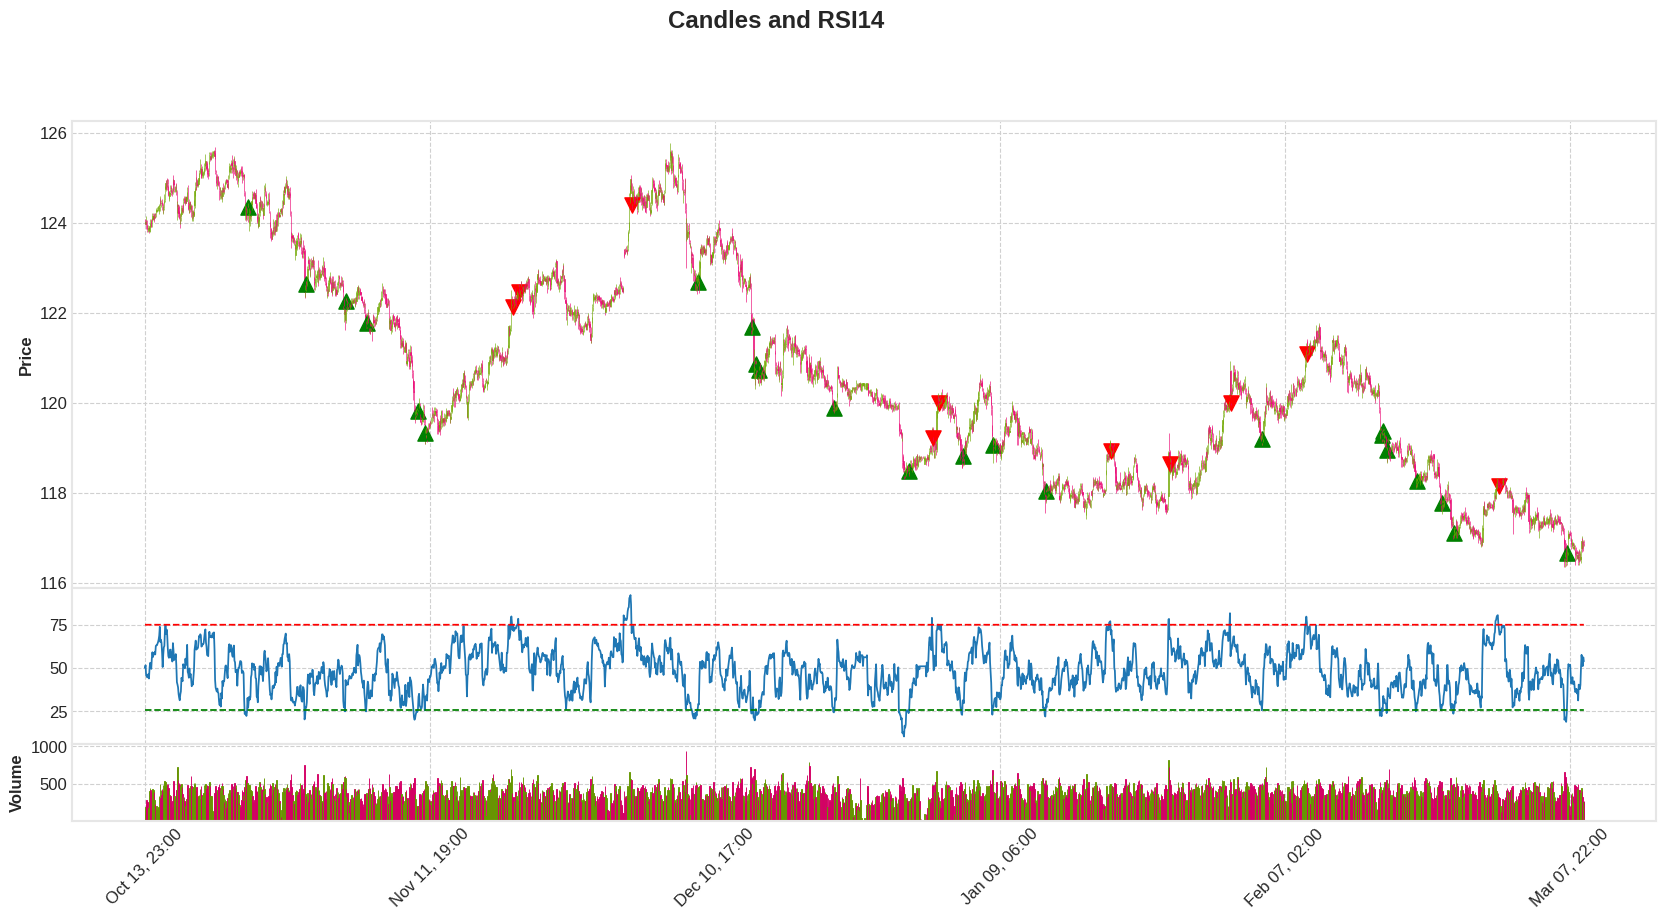

In [5]:
plot_df = df["2002-10-12 10:00:00":"2003-03-10"].copy(deep=True)

plot_df['rsi_lower'     ] = rsi_lower
plot_df['rsi_upper'     ] = rsi_upper
plot_df['short_position'] = np.nan
plot_df['long_position' ] = np.nan
plot_df['short_position'] = plot_df[plot_df['position']==-1]['Close']
plot_df['long_position' ] = plot_df[plot_df['position']== 1]['Close']

apds = [
    mpf.make_addplot(plot_df['long_position' ], panel=0, type='scatter', markersize=120, marker='^', color='g'),
    mpf.make_addplot(plot_df['short_position'], panel=0, type='scatter', markersize=120, marker='v', color='r'),
    mpf.make_addplot(plot_df[f"rsi_{rsi_period}"], panel=1),
    mpf.make_addplot(plot_df[f"rsi_lower"], panel=1, color='g', linestyle='--'),
    mpf.make_addplot(plot_df[f"rsi_upper"], panel=1, color='r', linestyle='--'),
    ]

mpf.plot(
    plot_df, type='candle', addplot=apds, figsize=(22, 10), figscale=1.6, 
    title=f"Candles and RSI{rsi_period}",
    style='binance', volume=True, volume_panel=2, panel_ratios=(6,2,1), show_nontrading=False
    )

In [6]:
# Mapping entry prices from higher timeframe to lower timeframe in order to analyze slippages
# Scenario is like when signal is generated based on Close price of higher timerframe, so we 
# are kind of hopefully open a position on that Close price will be executed fairly, but
# in reality there will be a lot of fluctuations in the lower timeframe so there is no guarentee,
# meaning order will be executed at different price which is called Slippage. 
# So taking into account slippage into trading strategy development would prevent losses occured
# by this phenomenom and of course strategy will be more realistic tho.

df_eval = df_.copy()

df_eval['long_entry' ] = np.nan
df_eval['short_entry'] = np.nan

for idx, row in df[df['position']==1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'long_entry'] = float(row['Close'])

for idx, row in df[df['position']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.at[idx, 'short_entry'] = float(row['Close'])


timeframe_by_minute = 60
look_ahead_shift    = 1
df_eval['long_entry' ] = df_eval['long_entry' ].shift(timeframe_by_minute+look_ahead_shift)
df_eval['short_entry'] = df_eval['short_entry'].shift(timeframe_by_minute+look_ahead_shift)


# Multiple scenarios are like how many minutes after an order executed.
for executed_after_minute in range(1, 5+1):
    df_eval[f"Close_{executed_after_minute}"        ] = df_eval[f"Close"].shift(executed_after_minute)
    df_eval[f"long_slippage{executed_after_minute}" ] = np.nan
    df_eval[f"short_slippage{executed_after_minute}"] = np.nan


# How much changes occured after order executed
for slippage_level in range(1, 5+1):
    df_eval[f"long_slippage{slippage_level}" ] = df_eval[f"Close_{slippage_level}"] - df_eval[f"long_entry"            ]
    df_eval[f"short_slippage{slippage_level}"] = df_eval[f"short_entry"           ] - df_eval[f"Close_{slippage_level}"]
    pass

# Convert slippages to bps
for slippage_level in range(1, 5+1):
    df_eval[f"long_slippage{slippage_level}_bps" ] = ((df_eval[f"long_slippage{slippage_level}" ]*100.0)/df_eval['Close'])*100.0
    df_eval[f"short_slippage{slippage_level}_bps"] = ((df_eval[f"short_slippage{slippage_level}"]*100.0)/df_eval['Close'])*100.0


df_eval

,Open,High,Low,Close,Volume,long_entry,short_entry,Close_1,long_slippage1,short_slippage1,...,long_slippage1_bps,short_slippage1_bps,long_slippage2_bps,short_slippage2_bps,long_slippage3_bps,short_slippage3_bps,long_slippage4_bps,short_slippage4_bps,long_slippage5_bps,short_slippage5_bps
datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-02 23:01:00+00:00,102.140,102.150,102.130,102.140,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 23:10:00+00:00,102.120,102.120,102.120,102.120,1,NaN,NaN,102.140,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 23:12:00+00:00,102.120,102.150,102.120,102.150,4,NaN,NaN,102.120,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 23:13:00+00:00,102.140,102.140,102.130,102.130,2,NaN,NaN,102.150,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 23:14:00+00:00,102.140,102.140,102.140,102.140,1,NaN,NaN,102.130,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 03:12:00+00:00,143.859,143.872,143.853,143.872,24,NaN,NaN,143.859,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-10 03:13:00+00:00,143.872,143.872,143.867,143.868,13,NaN,NaN,143.872,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-10 03:14:00+00:00,143.868,143.875,143.853,143.864,30,NaN,NaN,143.868,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


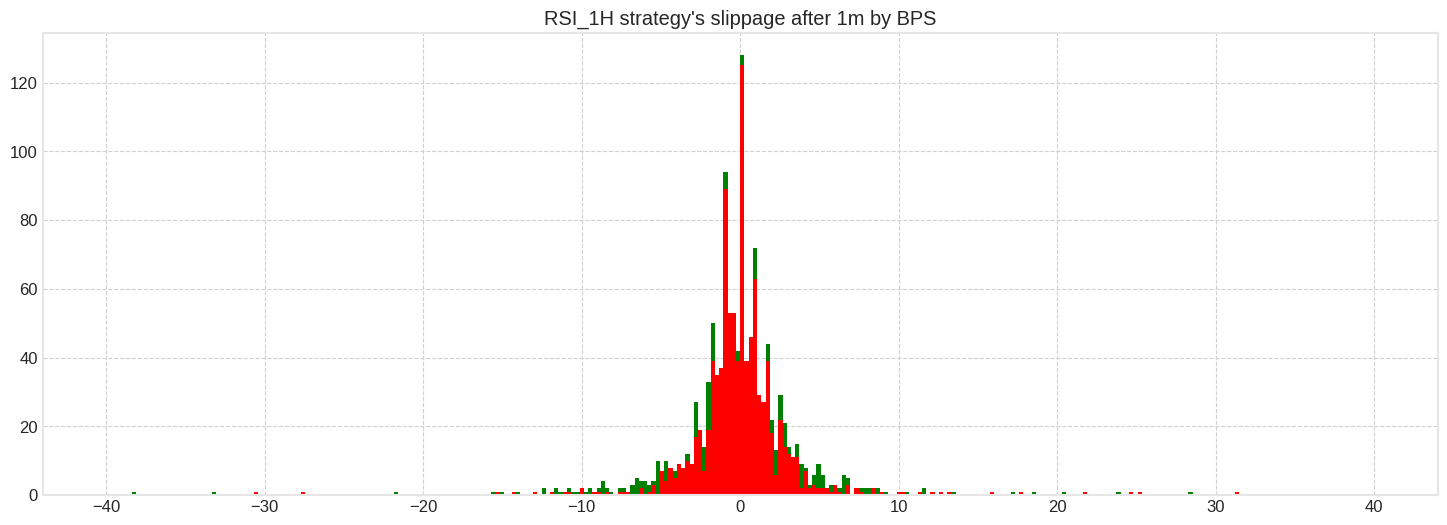

In [14]:
# Slippage by bps distribution after order executed x minutes
slippage_level = 1
_, axs = plt.subplots(1, figsize=(18, 6))
l1 = axs.hist(df_eval[df_eval[f"long_slippage{slippage_level}_bps" ].notnull()][f"long_slippage{slippage_level}_bps" ].values, bins=300, range=(-40.0, 40.0), label="Long slippage BPS" , color='g')
l2 = axs.hist(df_eval[df_eval[f"short_slippage{slippage_level}_bps"].notnull()][f"short_slippage{slippage_level}_bps"].values, bins=300, range=(-40.0, 40.0), label="Short slippage BPS", color='r')
axs.set_title(f"RSI_1H strategy's slippage after {slippage_level}m by BPS")
plt.show();

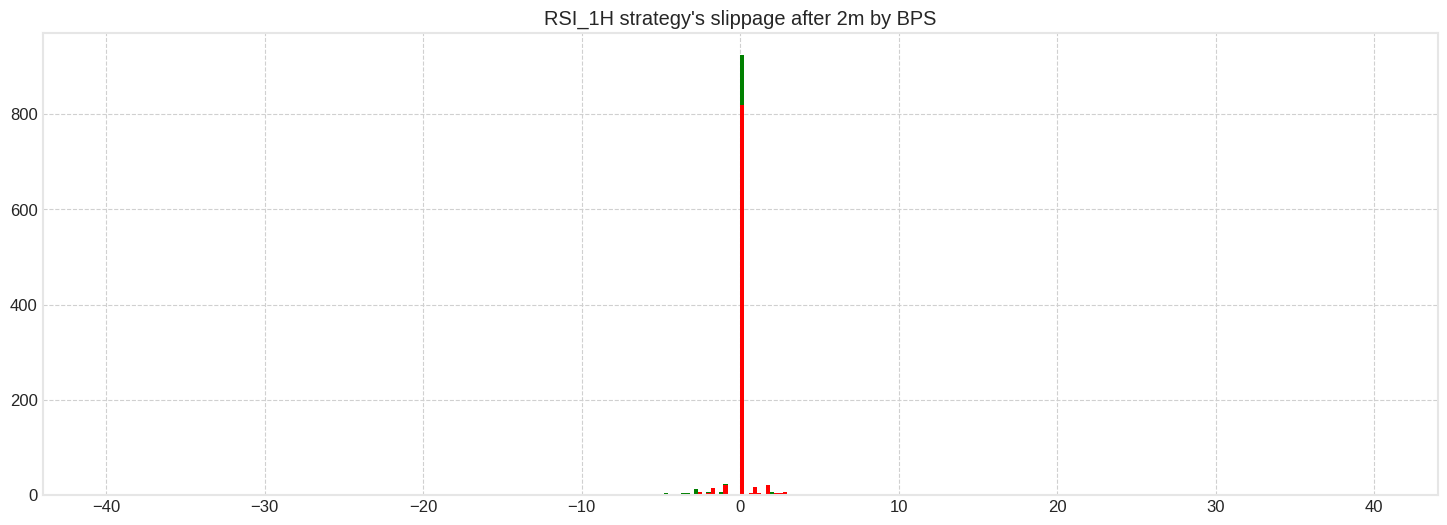

In [15]:
# Slippage by bps distribution after order executed x minutes
slippage_level = 2
_, axs = plt.subplots(1, figsize=(18, 6))
l1 = axs.hist(df_eval[df_eval[f"long_slippage{slippage_level}_bps" ].notnull()][f"long_slippage{slippage_level}_bps" ].values, bins=300, range=(-40.0, 40.0), label="Long slippage BPS" , color='g')
l2 = axs.hist(df_eval[df_eval[f"short_slippage{slippage_level}_bps"].notnull()][f"short_slippage{slippage_level}_bps"].values, bins=300, range=(-40.0, 40.0), label="Short slippage BPS", color='r')
axs.set_title(f"RSI_1H strategy's slippage after {slippage_level}m by BPS")
plt.show();

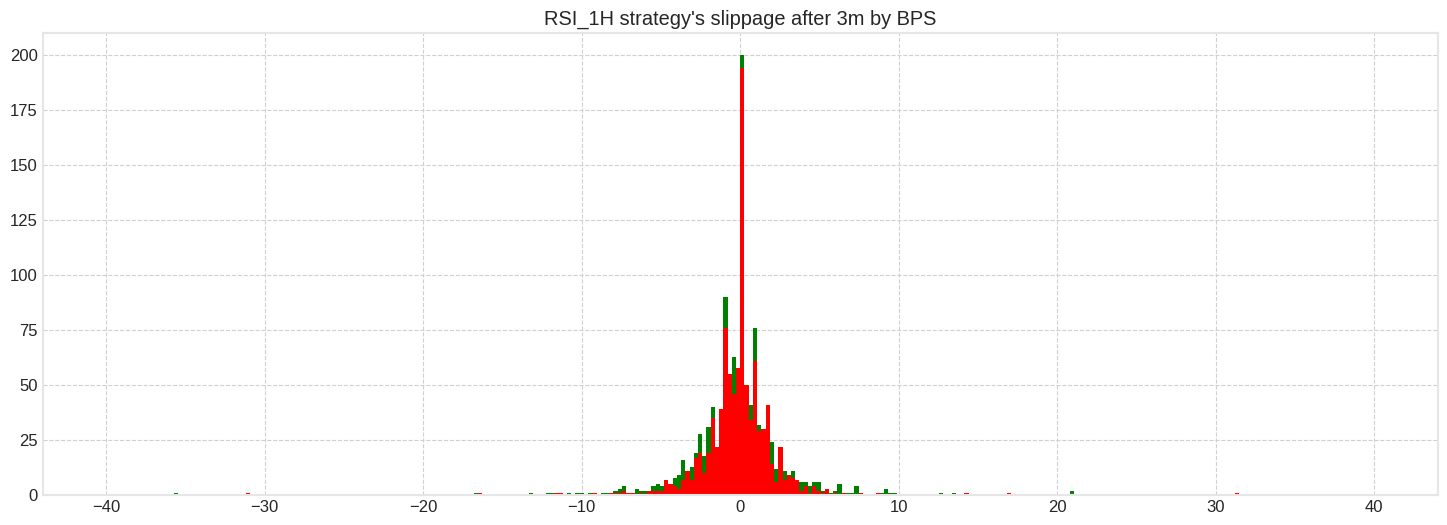

In [16]:
# Slippage by bps distribution after order executed x minutes
slippage_level = 3
_, axs = plt.subplots(1, figsize=(18, 6))
l1 = axs.hist(df_eval[df_eval[f"long_slippage{slippage_level}_bps" ].notnull()][f"long_slippage{slippage_level}_bps" ].values, bins=300, range=(-40.0, 40.0), label="Long slippage BPS" , color='g')
l2 = axs.hist(df_eval[df_eval[f"short_slippage{slippage_level}_bps"].notnull()][f"short_slippage{slippage_level}_bps"].values, bins=300, range=(-40.0, 40.0), label="Short slippage BPS", color='r')
axs.set_title(f"RSI_1H strategy's slippage after {slippage_level}m by BPS")
plt.show();

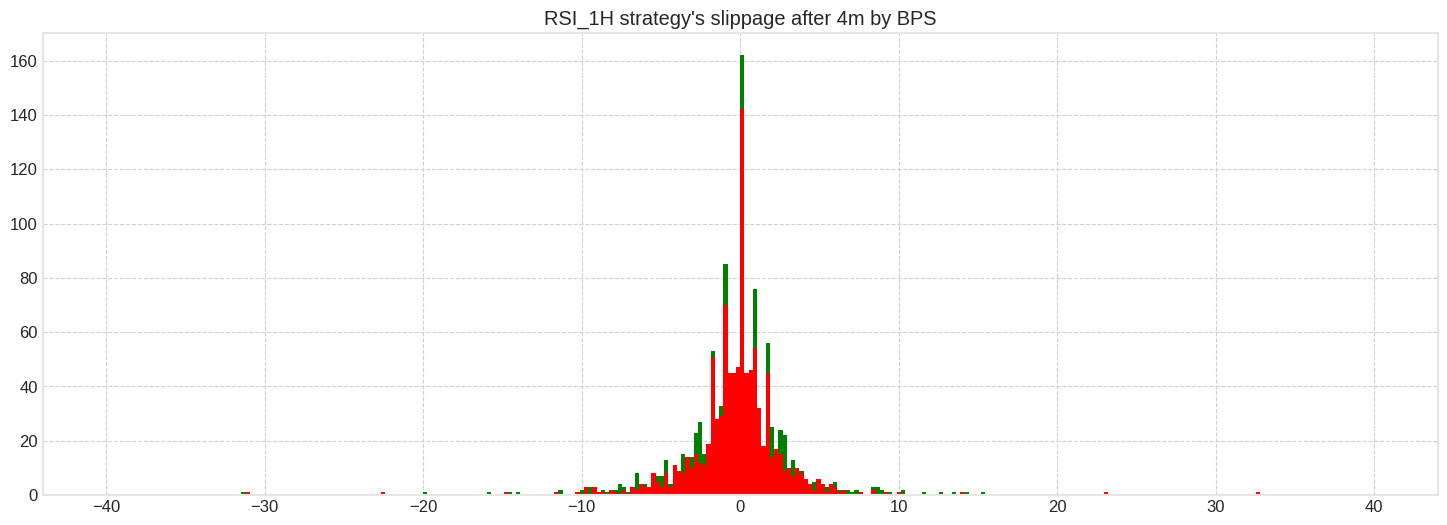

In [17]:
# Slippage by bps distribution after order executed x minutes
slippage_level = 4
_, axs = plt.subplots(1, figsize=(18, 6))
l1 = axs.hist(df_eval[df_eval[f"long_slippage{slippage_level}_bps" ].notnull()][f"long_slippage{slippage_level}_bps" ].values, bins=300, range=(-40.0, 40.0), label="Long slippage BPS" , color='g')
l2 = axs.hist(df_eval[df_eval[f"short_slippage{slippage_level}_bps"].notnull()][f"short_slippage{slippage_level}_bps"].values, bins=300, range=(-40.0, 40.0), label="Short slippage BPS", color='r')
axs.set_title(f"RSI_1H strategy's slippage after {slippage_level}m by BPS")
plt.show();

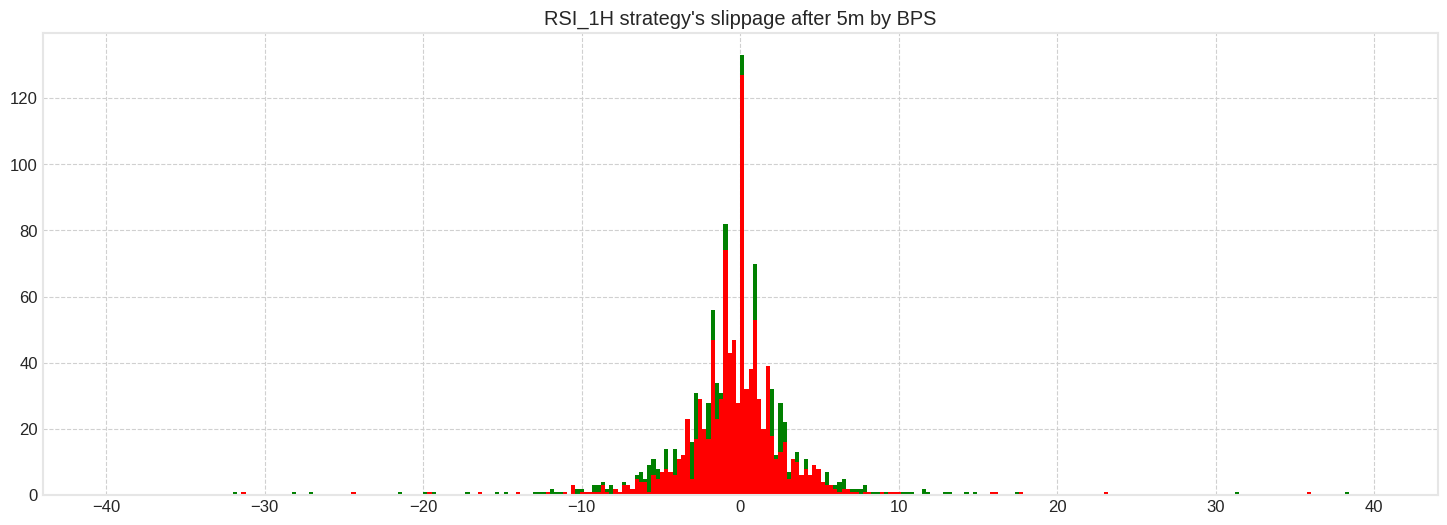

In [18]:
# Slippage by bps distribution after order executed x minutes
slippage_level = 5
_, axs = plt.subplots(1, figsize=(18, 6))
l1 = axs.hist(df_eval[df_eval[f"long_slippage{slippage_level}_bps" ].notnull()][f"long_slippage{slippage_level}_bps" ].values, bins=300, range=(-40.0, 40.0), label="Long slippage BPS" , color='g')
l2 = axs.hist(df_eval[df_eval[f"short_slippage{slippage_level}_bps"].notnull()][f"short_slippage{slippage_level}_bps"].values, bins=300, range=(-40.0, 40.0), label="Short slippage BPS", color='r')
axs.set_title(f"RSI_1H strategy's slippage after {slippage_level}m by BPS")
plt.show();